Razi Haider

19I-1762

DS-N

Data mining project

Libraries:

In [3]:
import pandas as pd
import numpy as np
import re
import spacy
import torch
from PIL import Image
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [6]:
import os
from skimage import io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [7]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
from tqdm import tqdm
import os
import shutil

In [9]:
import cv2

Enabling GPU:

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [288]:
# import matplotlib.cbook as cbook
# import matplotlib.image as image
# import matplotlib.pyplot as plt

Data loading

In [11]:
df = pd.read_csv('/content/drive/MyDrive/SEMESTER6/DM/Data_labels.csv')

In [12]:
df['Image_name'] = df['Image_name'] + '.jpg'

In [13]:
df

,Image_name,level
0,IMG_1.jpg,4
1,IMG_2.jpg,4
2,IMG_3.jpg,4
3,IMG_4.jpg,4
4,IMG_5.jpg,4
...,...,...
511,IMG_512.jpg,2
512,IMG_513.jpg,2
513,IMG_514.jpg,2
514,IMG_515.jpg,2


Flattening and resizing images for kmeans clustering

In [31]:
klist = []
for i in df['Image_name']:
  image = cv2.imread('/content/drive/MyDrive/SEMESTER6/DM/Images/' + i)
  image = cv2.resize(image, (100, 100), interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  klist.append(image.flatten())

I have commented this box because of its high run time. You can run this, but I have provided the graph itself for Kelbow.

In [ ]:
# m = KMeans()
# v = KElbowVisualizer(m, k=(2, 20))
# v.fit(np.array(klist))
# v.show()

According to the kelbow graph, k=7 is the best number for clustering

In [32]:
k = 7
clusters = KMeans(k, random_state = 40)
clusters.fit(klist)

KMeans(n_clusters=7, random_state=40)

Here I am creating a new dataframe which consists of clustered labels with k = 7.

In [33]:
img_name = []
for i in df['Image_name']:
  img_name.append(i)

In [34]:
image_cluster = pd.DataFrame(img_name,columns=['image'])
image_cluster["clusterid"] = clusters.labels_
image_cluster

,image,clusterid
0,IMG_1.jpg,1
1,IMG_2.jpg,1
2,IMG_3.jpg,2
3,IMG_4.jpg,4
4,IMG_5.jpg,1
...,...,...
511,IMG_512.jpg,6
512,IMG_513.jpg,4
513,IMG_514.jpg,2
514,IMG_515.jpg,4


In [35]:
image_cluster.to_csv('clustered.csv', index=False)

The code below was used to segment images using kmeans with k=7 and to save the new segmented images to another folder (PIL_SEG).

In [22]:
# segArr = []
# for i in df['Image_name']:
#   print(i)
#   # Read in the image
#   image = cv2.imread('/content/drive/MyDrive/SEMESTER6/DM/Images/' + i)
#   image = cv2.resize(image, (100, 100), interpolation = cv2.INTER_AREA)
#   # Change color to RGB (from BGR)
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   #plt.imshow(image)
#   pixel_vals = image.reshape((-1,3))
#   # Convert to float type
#   pixel_vals = np.float32(pixel_vals)
#   criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
  
#   # then perform k-means clustering wit h number of clusters defined as 3
#   #also random centres are initially choosed for k-means clustering
#   k = 7
#   retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  
#   # convert data into 8-bit values
#   centers = np.uint8(centers)
#   segmented_data = centers[labels.flatten()]
  
#   # reshape data into the original image dimensions
#   segmented_image = segmented_data.reshape((image.shape))
#   pil_im = Image.fromarray(segmented_image)
# # im_name = im +".jpg"
#   pil_im.save('/content/drive/MyDrive/SEMESTER6/DM/PIL_SEG/'+i)
#   # plt.imshow(segmented_image)
#   # plt.grid(False)
#   # plt.xticks([])
#   # plt.yticks([])
#   # plt.savefig('/content/drive/MyDrive/SEMESTER6/DM/Segments/'+i)

Select 70% data

I used a for loop to select 70% of rows of each label. I stored the newly generated data in another dataframe (new_df).

In [36]:
new_df = pd.DataFrame(columns=['image', 'clusterid'])
for i in image_cluster['clusterid'].unique():
  temp = image_cluster[image_cluster['clusterid'] == i]
  per = int(len(temp)*0.7)
  tempdf = temp.sample(n = per)
  new_df = pd.concat([new_df, tempdf])

In [37]:
new_df

,image,clusterid
286,IMG_287.jpg,1
438,IMG_439.jpg,1
253,IMG_254.jpg,1
277,IMG_278.jpg,1
16,IMG_17.jpg,1
...,...,...
84,IMG_85.jpg,6
167,IMG_168.jpg,6
103,IMG_104.jpg,6
21,IMG_22.jpg,6


In [38]:
new_df = new_df.sort_index(ascending=True)
new_df

,image,clusterid
3,IMG_4.jpg,4
4,IMG_5.jpg,1
6,IMG_7.jpg,2
8,IMG_9.jpg,4
11,IMG_12.jpg,2
...,...,...
507,IMG_508.jpg,0
508,IMG_509.jpg,4
509,IMG_510.jpg,6
511,IMG_512.jpg,6


I stored the final dataframe as a csv in my folder so that I don't have to run previous code cells again. You can uncommented the last line of the following cell to save csv.

In [39]:
image_cluster = new_df.reset_index(drop=True)
image_cluster['clusterid'] = image_cluster['clusterid'].astype('int')
#image_cluster.to_csv('/content/drive/MyDrive/SEMESTER6/DM/dataUsed1.csv', index=False)

In [40]:
# image_cluster

Loading new data

In [43]:
image_cluster = pd.read_csv('/content/drive/MyDrive/SEMESTER6/DM/dataUsed1.csv')

In [44]:
image_cluster

,image,clusterid
0,IMG_4.jpg,4
1,IMG_5.jpg,1
2,IMG_7.jpg,2
3,IMG_9.jpg,4
4,IMG_12.jpg,2
...,...,...
354,IMG_508.jpg,0
355,IMG_509.jpg,4
356,IMG_510.jpg,6
357,IMG_512.jpg,6


Non segment images

ANN

Custom dataloader which converts labels and images in the form suitable for neural networks.

In [45]:
#reference: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/custom_dataset_txt/loader_customtext.py

class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None, freq_threshold = 5):
        self.df = csv_file.copy()
        self.img = self.df['image']
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.root_dir, self.df.iloc[index, 0])).convert("RGB")
        y_label = torch.tensor(int(self.df.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
    
            
        return (image, y_label)

Transforming the images in the required form.

In [46]:
mean = [0.4, 0.5, 0.5]
std = [0.4, 0.5, 0.5]


transform = transforms.Compose(
    [transforms.Resize((100, 100)),
     #transforms.Grayscale(num_output_channels=3),
     transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

In [72]:
dataset = ImageDataset(csv_file = image_cluster, root_dir = '/content/drive/MyDrive/SEMESTER6/DM/Images/', transform = transform)

The data was splitted in a roughly 70/30 manner. 70 being training size and 30 being testing size.

In [73]:
train_set, test_set = torch.utils.data.random_split(dataset, [259,100])

Loading training and testing data

In [74]:
train_loader = DataLoader(dataset = train_set, batch_size = 16, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size = 16, shuffle=True)

Neural network structure with 4 hidden layers and relu as activation function.

In [75]:
class NN(nn.Module):    
    def __init__(self):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100*100*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 7)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Entropy loss and Adam optimizer used.

In [76]:
net = NN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [77]:
accuracies = []
time_taken = []
models = []

All of the neural networks are run till 20 epochs and time was stored along with accuracies and losses.

Training

In [78]:
n_epochs=20
loss_list=[]
tot_loss=0

#n_epochs
start = time.process_time()
for epoch in range(n_epochs):
    print('epoch:',epoch)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data 
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() 
        z=net(inputs)
        loss=criterion(z,labels) 
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data)
        tot_loss+=loss.data
        print('loss:', tot_loss/len(loss_list))

tt = time.process_time() - start
time_taken.append(tt/20)

epoch: 0
loss: tensor(1.9538, device='cuda:0')
loss: tensor(1.9673, device='cuda:0')
loss: tensor(1.8980, device='cuda:0')
loss: tensor(1.9923, device='cuda:0')
loss: tensor(2.0313, device='cuda:0')
loss: tensor(2.0061, device='cuda:0')
loss: tensor(2.0005, device='cuda:0')
loss: tensor(1.9899, device='cuda:0')
loss: tensor(1.9752, device='cuda:0')
loss: tensor(1.9858, device='cuda:0')
loss: tensor(1.9796, device='cuda:0')
loss: tensor(1.9779, device='cuda:0')
loss: tensor(1.9708, device='cuda:0')
loss: tensor(1.9634, device='cuda:0')
loss: tensor(1.9534, device='cuda:0')
loss: tensor(1.9425, device='cuda:0')
loss: tensor(1.9394, device='cuda:0')
epoch: 1
loss: tensor(1.9340, device='cuda:0')
loss: tensor(1.9214, device='cuda:0')
loss: tensor(1.9145, device='cuda:0')
loss: tensor(1.8928, device='cuda:0')
loss: tensor(1.8951, device='cuda:0')
loss: tensor(1.8864, device='cuda:0')
loss: tensor(1.8660, device='cuda:0')
loss: tensor(1.8597, device='cuda:0')
loss: tensor(1.8602, device='cud

Testing

In [80]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy:', 100 * correct // total, '%')
accuracies.append(100 * correct // total)
models.append('Original ANN')

Accuracy: 89 %


CNN

In [81]:
class NetC(nn.Module):
  def __init__(self):
    super(NetC, self).__init__()
    self.convo1 = nn.Conv2d(3, 10, 7)
    self.pool1 = nn.MaxPool2d(1, stride = 1)
    self.convo2 = nn.Conv2d(10, 21, 5)
    self.pool2 = nn.MaxPool2d(4, stride = 2)
    self.out = nn.Linear(40656, 7)


    

  def forward(self, x):
      # Pass the input tensor through each of our operations
      x = self.pool1(F.relu(self.convo1(x)))
      x = self.pool2(F.relu(self.convo2(x)))
      x = torch.flatten(x, 1)
      x = self.out(x)
      return x

In [82]:
cnet = NetC().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnet.parameters(), lr=0.001)

In [83]:
start = time.process_time()
n_epochs=20
loss_list=[]
tot_loss=0

#n_epochs
for epoch in range(n_epochs):
    print('epoch:', epoch)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data 
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        z = cnet(inputs)
        loss=criterion(z,labels) 
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data)
        tot_loss+=loss.data
        print('loss:', tot_loss/len(loss_list))
tt = time.process_time() - start
time_taken.append(tt/20)

epoch: 0
loss: tensor(1.9096, device='cuda:0')
loss: tensor(5.4362, device='cuda:0')
loss: tensor(5.5017, device='cuda:0')
loss: tensor(4.8987, device='cuda:0')
loss: tensor(4.4129, device='cuda:0')
loss: tensor(3.9609, device='cuda:0')
loss: tensor(3.6630, device='cuda:0')
loss: tensor(3.3942, device='cuda:0')
loss: tensor(3.1974, device='cuda:0')
loss: tensor(3.0189, device='cuda:0')
loss: tensor(2.8998, device='cuda:0')
loss: tensor(2.7787, device='cuda:0')
loss: tensor(2.6828, device='cuda:0')
loss: tensor(2.6005, device='cuda:0')
loss: tensor(2.5243, device='cuda:0')
loss: tensor(2.4325, device='cuda:0')
loss: tensor(2.4022, device='cuda:0')
epoch: 1
loss: tensor(2.3229, device='cuda:0')
loss: tensor(2.2732, device='cuda:0')
loss: tensor(2.2069, device='cuda:0')
loss: tensor(2.1485, device='cuda:0')
loss: tensor(2.1101, device='cuda:0')
loss: tensor(2.0544, device='cuda:0')
loss: tensor(2.0046, device='cuda:0')
loss: tensor(1.9630, device='cuda:0')
loss: tensor(1.9152, device='cud

In [84]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy:', 100 * correct // total, '%')
accuracies.append(100 * correct // total)
models.append('Original CNN')

Accuracy: 82 %


Segmented Images

In [85]:
dataset2 = ImageDataset(csv_file = image_cluster, root_dir = '/content/drive/MyDrive/SEMESTER6/DM/PIL_SEG/', transform = transform)

ANN

In [86]:
train_set2, test_set2 = torch.utils.data.random_split(dataset2, [259,100])

In [87]:
train_loader2 = DataLoader(dataset = train_set2, batch_size = 16, shuffle=True)
test_loader2 = DataLoader(dataset = test_set2, batch_size = 16, shuffle=True)

In [88]:
class NN2(nn.Module):    
    def __init__(self):
        super(NN2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100*100*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 7)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [97]:
net2 = NN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)

In [98]:
n_epochs=20
loss_list=[]
tot_loss=0

#n_epochs
start = time.process_time()
for epoch in range(n_epochs):
    print('epoch:', epoch)
    for i, data in enumerate(train_loader2, 0):
        inputs, labels = data 
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() 
        z=net2(inputs)
        loss=criterion(z,labels) 
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data)
        tot_loss+=loss.data
        print('loss:', tot_loss/len(loss_list))
        #print(f'[{epoch+1}, {i+1:5d}] loss: {tot_loss/len(loss_list)}')

tt = time.process_time() - start
time_taken.append(tt/20)

epoch: 0
loss: tensor(2.0302, device='cuda:0')
loss: tensor(2.0083, device='cuda:0')
loss: tensor(1.9561, device='cuda:0')
loss: tensor(1.9787, device='cuda:0')
loss: tensor(2.0022, device='cuda:0')
loss: tensor(1.9677, device='cuda:0')
loss: tensor(1.9735, device='cuda:0')
loss: tensor(1.9919, device='cuda:0')
loss: tensor(1.9892, device='cuda:0')
loss: tensor(1.9964, device='cuda:0')
loss: tensor(1.9912, device='cuda:0')
loss: tensor(1.9851, device='cuda:0')
loss: tensor(1.9786, device='cuda:0')
loss: tensor(1.9780, device='cuda:0')
loss: tensor(1.9676, device='cuda:0')
loss: tensor(1.9500, device='cuda:0')
loss: tensor(1.9881, device='cuda:0')
epoch: 1
loss: tensor(1.9864, device='cuda:0')
loss: tensor(1.9697, device='cuda:0')
loss: tensor(1.9580, device='cuda:0')
loss: tensor(1.9477, device='cuda:0')
loss: tensor(1.9290, device='cuda:0')
loss: tensor(1.9178, device='cuda:0')
loss: tensor(1.9001, device='cuda:0')
loss: tensor(1.8930, device='cuda:0')
loss: tensor(1.8825, device='cud

In [100]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader2:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy:', 100 * correct // total, '%')
accuracies.append(100 * correct // total)
models.append('Segmented ANN')

Accuracy: 72 %


CNN

In [101]:
cnet2 = NetC().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnet2.parameters(), lr=0.001)

In [102]:
n_epochs=20
loss_list=[]
tot_loss=0

#n_epochs
start = time.process_time()
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader2, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() 
        z=cnet2(inputs)
        loss=criterion(z,labels) 
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data)
        tot_loss+=loss.data
        #print('loss:', tot_loss/len(loss_list))
        print(f'[{epoch+1}, {i+1:5d}] loss: {tot_loss/len(loss_list)}')

tt = time.process_time() - start
time_taken.append(tt/20)

[1,     1] loss: 1.9749897718429565
[1,     2] loss: 3.028160810470581
[1,     3] loss: 2.952047109603882
[1,     4] loss: 2.669943332672119
[1,     5] loss: 2.509552478790283
[1,     6] loss: 2.3853697776794434
[1,     7] loss: 2.2601559162139893
[1,     8] loss: 2.201730966567993
[1,     9] loss: 2.147418260574341
[1,    10] loss: 2.082688093185425
[1,    11] loss: 2.055716037750244
[1,    12] loss: 1.9998204708099365
[1,    13] loss: 1.9468086957931519
[1,    14] loss: 1.8993477821350098
[1,    15] loss: 1.8344963788986206
[1,    16] loss: 1.780226707458496
[1,    17] loss: 1.769706130027771
[2,     1] loss: 1.7198604345321655
[2,     2] loss: 1.6647095680236816
[2,     3] loss: 1.6410887241363525
[2,     4] loss: 1.6110526323318481
[2,     5] loss: 1.582584261894226
[2,     6] loss: 1.5427511930465698
[2,     7] loss: 1.5185434818267822
[2,     8] loss: 1.491211175918579
[2,     9] loss: 1.452704906463623
[2,    10] loss: 1.4334875345230103
[2,    11] loss: 1.4214146137237549
[2,  

In [103]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader2:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnet2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy:', 100 * correct // total, '%')
accuracies.append(100 * correct // total)
models.append('Segmented CNN')

Accuracy: 84 %


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

ML models

Flattening the images and resizing them so that we can use them as features in traditional ML models.

In [105]:
ns = []
for i in image_cluster['image']:
  image = cv2.imread('/content/drive/MyDrive/SEMESTER6/DM/Images/' + i)
  image = cv2.resize(image, (64, 64), interpolation = cv2.INTER_AREA)
  # Change color to RGB (from BGR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ns.append(image.flatten())

In [106]:
s = []
for i in image_cluster['image']:
  image = cv2.imread('/content/drive/MyDrive/SEMESTER6/DM/PIL_SEG/' + i)
  image = cv2.resize(image, (64, 64), interpolation = cv2.INTER_AREA)
  # Change color to RGB (from BGR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  s.append(image.flatten())

I used GuassianNB and Logistic Regression.

In [107]:
def NB(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    ada = GaussianNB()
    ada.fit(x_train, y_train)
    y_pred = ada.predict(x_test)
    return accuracy_score(y_pred, y_test)*100

def LOG(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    ada = LogisticRegression()
    ada.fit(x_train, y_train)
    y_pred = ada.predict(x_test)
    return accuracy_score(y_pred, y_test)*100

In [108]:
start = time.process_time()
a = NB(ns, image_cluster['clusterid'])
tt = time.process_time() - start
time_taken.append(tt)
accuracies.append(a)
models.append('Original NB')

In [109]:
start = time.process_time()
a = NB(s, image_cluster['clusterid'])
tt = time.process_time() - start
time_taken.append(tt)
accuracies.append(a)
models.append('Segmented NB')

In [110]:
start = time.process_time()
a = LOG(ns, image_cluster['clusterid'])
tt = time.process_time() - start
time_taken.append(tt)
accuracies.append(a)
models.append('Original LR')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [111]:
start = time.process_time()
a = LOG(s, image_cluster['clusterid'])
tt = time.process_time() - start
time_taken.append(tt)
accuracies.append(a)
models.append('Segmented LR')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Visualization

In [123]:
accuracies = accuracies[1:]

In [124]:
models = models[1:]

The following are the graphs that reflect each model's performance, including time taken, accuracies, and loss (for NN models).

In [115]:
from matplotlib.pyplot import figure

Text(0.5, 1.0, 'Accuracies by each model')

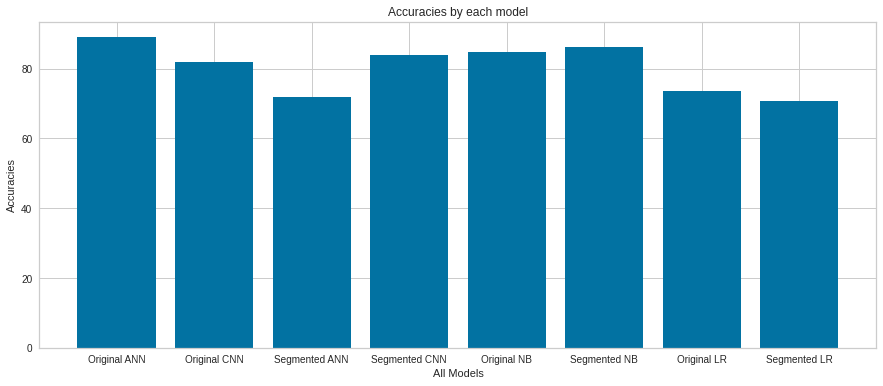

In [128]:
figure(figsize=(15, 6))
plt.bar(models,accuracies)
plt.xlabel('All Models')
plt.ylabel('Accuracies')
plt.title('Accuracies by each model')

Text(0.5, 1.0, 'Time taken by each model')

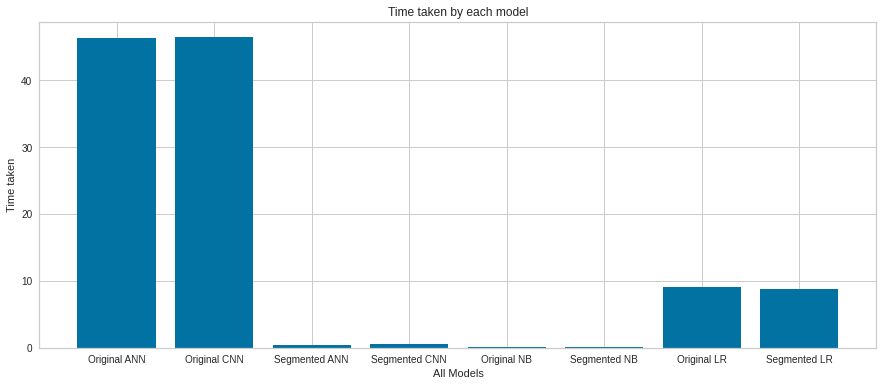

In [127]:
figure(figsize=(15, 6))
plt.bar(models, time_taken)
plt.xlabel('All Models')
plt.ylabel('Time taken')
plt.title('Time taken by each model')

Text(0.5, 1.0, 'Final losses of each NN model')

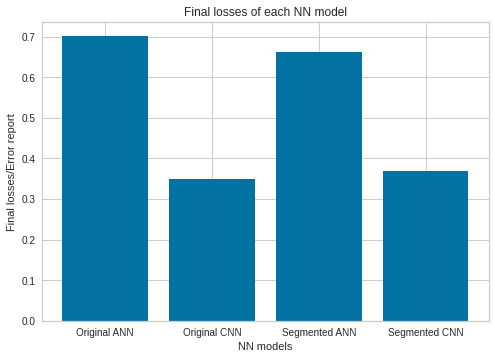

In [129]:
final_losses = [0.7016, 0.3490, 0.6634, 0.3680]
nn_models = ['Original ANN', 'Original CNN', 'Segmented ANN', 'Segmented CNN']
plt.bar(nn_models, final_losses)
plt.xlabel('NN models')
plt.ylabel('Final losses/Error report')
plt.title('Final losses of each NN model')